# Importing Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'BkUCpnyJ9KhyPF7rxiX8'

# Importing Data

In [3]:
# Importing the Inflation Rates - Consumer Price Index : Germany

data = quandl.get('RATEINF/CPI_DEU')

In [4]:
data.head()

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [5]:
data.shape

(389, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

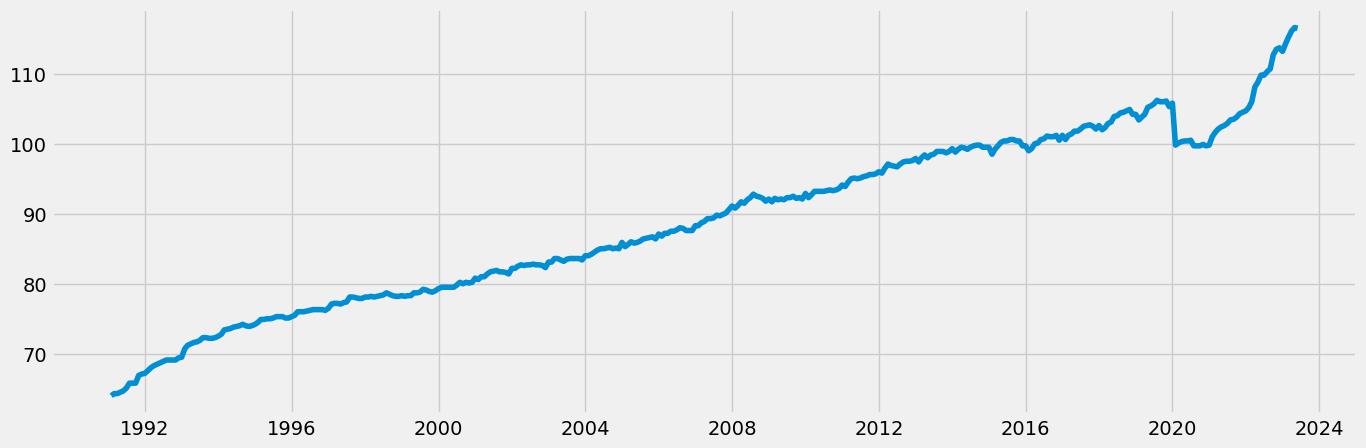

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# Subsetting, Wrangling, and Cleaning Time Series Data

#Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

data_2.tail()

data_2

#Set the "Date" column as the index

from datetime import datetime

data_2['datetime'] = pd.to_datetime(data_2['Date']) # Create a datetime column from "Date.""
data_2 = data_2.set_index('datetime') # Set the datetime as the index of the dataframe.
data_2.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_2.head()

#Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_2)

In [9]:
# Check for missing values 

data.isnull().sum() 

# No missing values

Value    0
dtype: int64

In [10]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

# 157 duplicate values

157

print(dups)

#Create new dataframe by dropping the duplicates

dups_clean =  data_2.drop_duplicates()

dups_clean.shape

# Time Series Analysis : Decomposition

In [11]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 1)

In [12]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

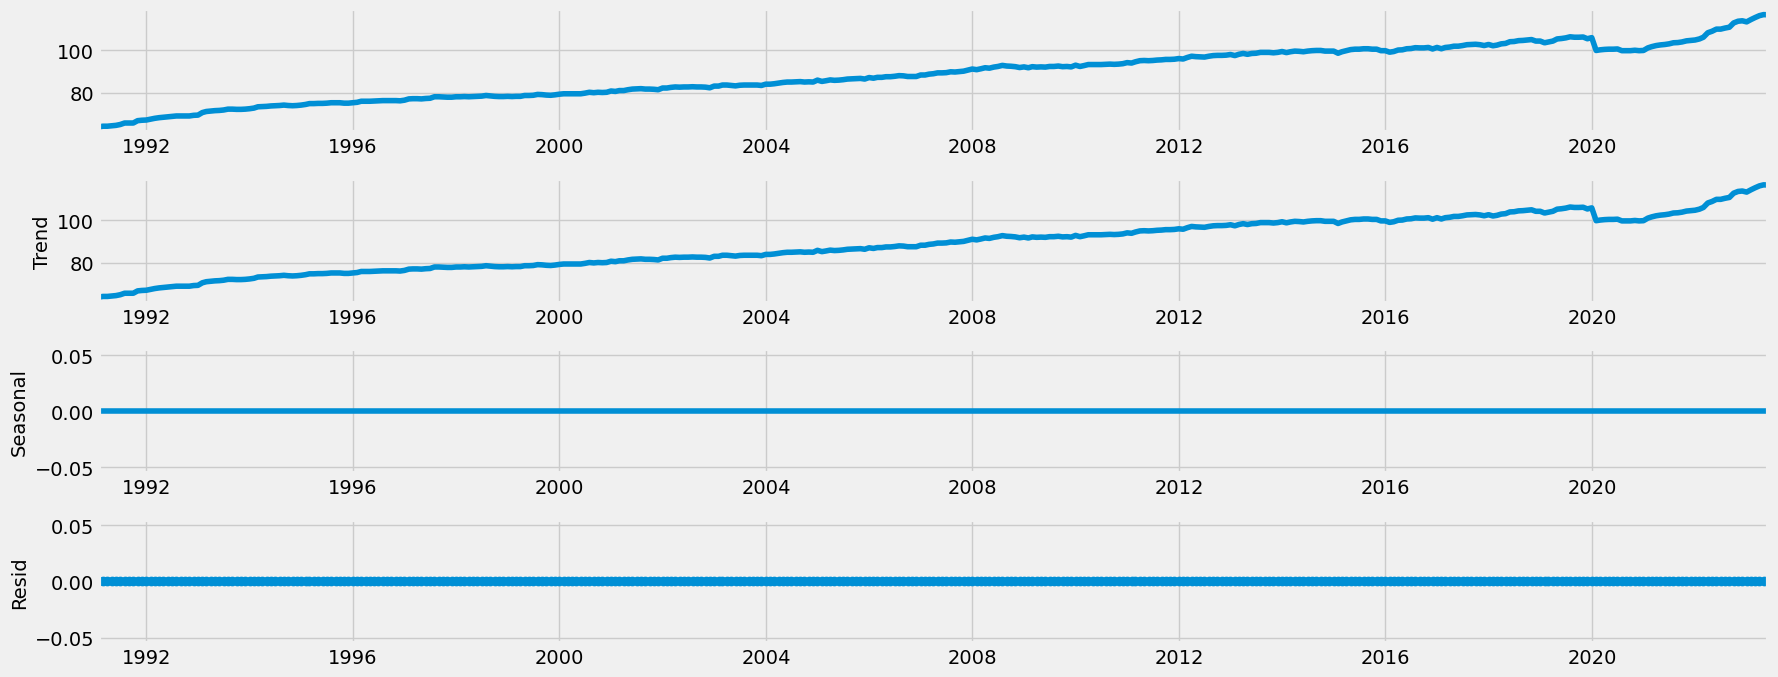

In [13]:
# Plot the separate components

decomposition.plot()
plt.show()

# Testing for Stationarity

In [14]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.423929
p-value                          0.982368
Number of Lags Used             12.000000
Number of Observations Used    376.000000
Critical Value (1%)             -3.447862
Critical Value (5%)             -2.869258
Critical Value (10%)            -2.570881
dtype: float64


**The 'Test Statistic' value 0.423929 is larger than the critical value -2.869258, hence the null can't be rejeted. </br>
This means that there is a unit root in the data, and the data is non-stationary.** 

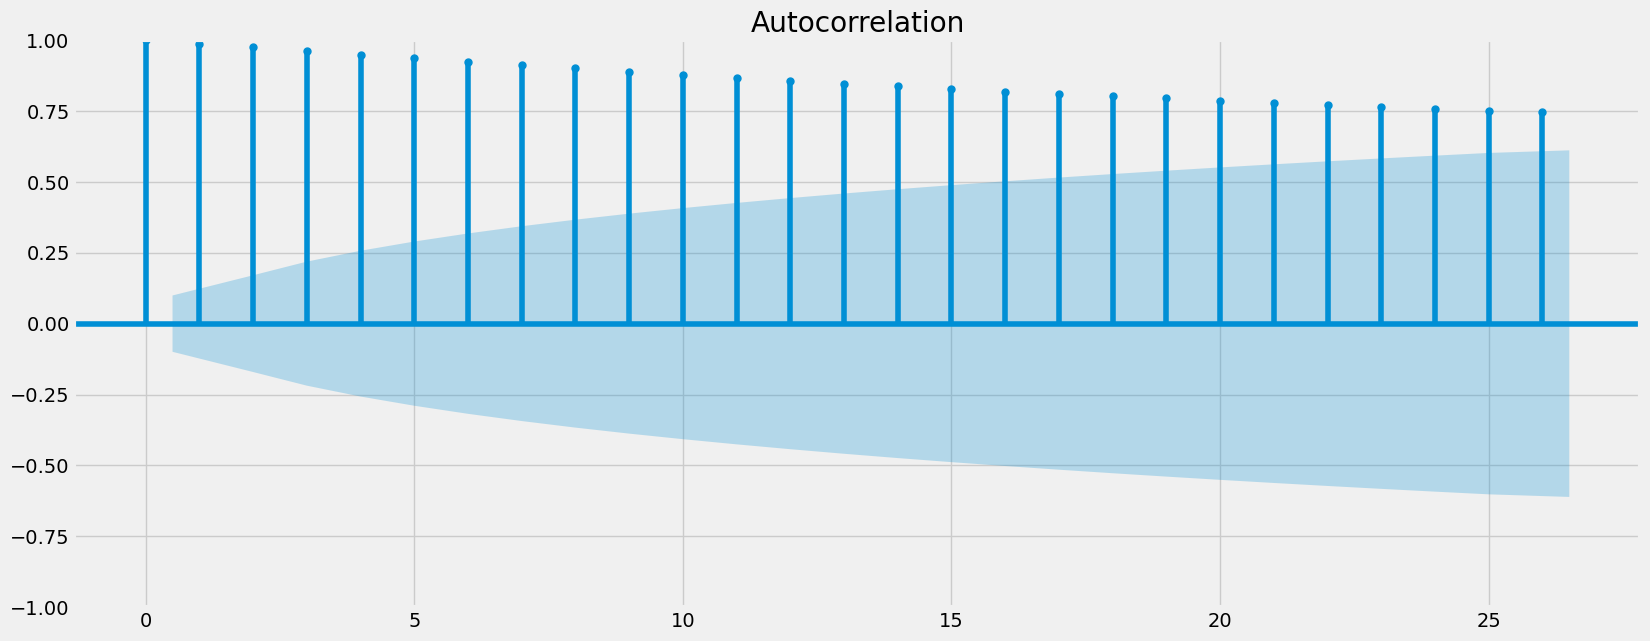

In [15]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

**It can be seen that the lines have gone above the blue edgde of the confidence interval, indicating that the lags are significantly correlated with each other. And since most of the lines have gone beyond the blue line, it means the data is non-stationary.**

# Stationarizing the Inflation Rates Data

In [16]:
data_diff = data - data.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [17]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [18]:
data_diff.head()

,Value
Date,
1991-02-28,0.3
1991-03-31,0.0
1991-04-30,0.2
1991-05-31,0.2
1991-06-30,0.4


In [19]:
data_diff.columns

Index(['Value'], dtype='object')

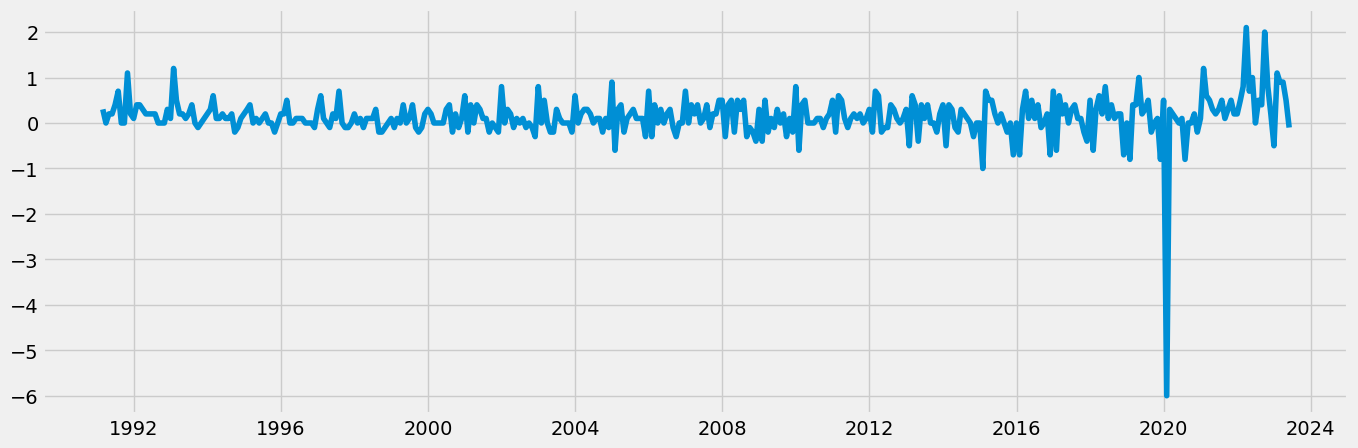

In [20]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [21]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.348933
p-value                          0.012828
Number of Lags Used             11.000000
Number of Observations Used    376.000000
Critical Value (1%)             -3.447862
Critical Value (5%)             -2.869258
Critical Value (10%)            -2.570881
dtype: float64


**The 'Test Statistic' value -3.348933 is smaller than the critical value -2.869258, hence the null can be rejeted. </br>
This means that the data is stationary.</br>
The p-value 0.012828 is also less than 0.05.** 

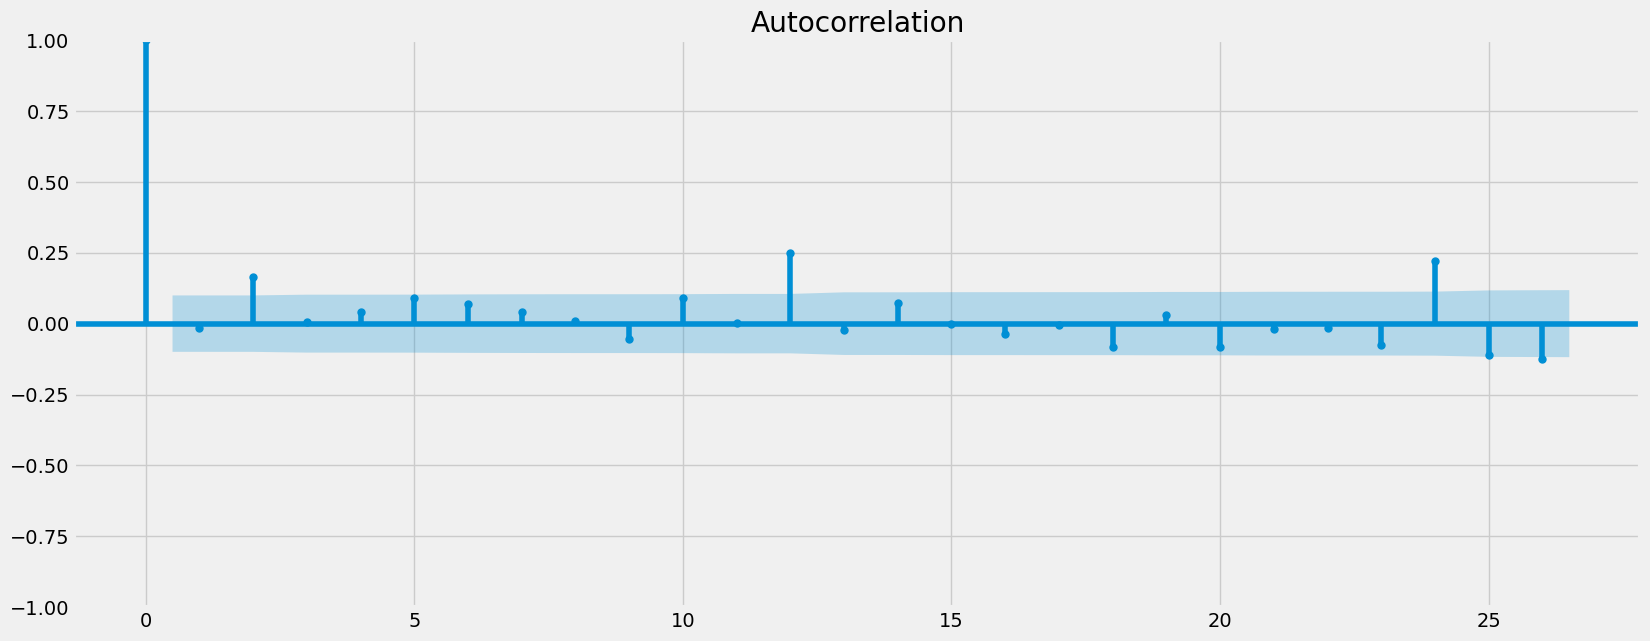

In [22]:
plot_acf(data_diff)
plt.show()

**It can be seen that the autocorrelation plot has improved. And most of the lines are well within the blue line, which means that the data is stationary but the stationarity is weak.**